# Construct Index Fund using Subgradient Descent

The objective function $L(u)$ may be equivalently stated as
$$
L(u)=\max \sum_{i=1}^{n} \sum_{j=1}^{n}\left(\rho_{i j}-u_{i}\right) x_{i j}+\sum_{i=1}^{n} u_{i}
$$
Let
$$
\left(\rho_{i j}-u_{i}\right)^{+}=\left\{\begin{array}{cc}
\left(\rho_{i j}-u_{i}\right) & \text { if } \rho_{i j}-u_{i}>0 \\
0 & \text { otherwise }
\end{array}\right.
$$
and
$$
C_{j}=\sum_{i=1}^{n}\left(\rho_{i j}-u_{i}\right)^{+}
$$
Then
\begin{gathered}
L(u)=\max \sum_{j=1}^{n} C_{j} y_{j}+\sum_{i=1}^{n} u_{i} \\
\text { subject to } \sum_{j=1}^{n} y_{j}=q \\
y_{j}=0 \text { or } 1 \text { for } j=1, \ldots, n .
\end{gathered}

In [1]:
import numpy as np
import pandas as pd
import math
from tqdm import tqdm
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
from sklearn import metrics
import datetime
import seaborn as sns
import cplex
import heapq
yf.pdr_override()

In [2]:
DJI_COM = pd.read_excel('DJICOM.xlsx')

stocks_data = pdr.get_data_yahoo(DJI_COM["COM"].to_list(), start='2012-01-01', end='2021-06-01')['Close']
stocks_data.head()

[*********************100%***********************]  30 of 30 completed


,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,14.686786,64.110001,48.389999,74.220001,93.980003,25.299999,18.629999,110.370003,38.310001,NaN,...,36.545803,26.770000,24.202499,66.830002,58.990002,51.490002,25.747499,39.730000,33.060001,60.330002
2012-01-04,14.765714,63.759998,48.240002,74.330002,94.849998,24.370001,18.990000,110.180000,38.849998,NaN,...,36.583969,27.400000,24.555000,66.800003,58.750000,52.240002,25.287500,39.209999,32.830002,59.709999
2012-01-05,14.929643,64.410004,48.799999,73.529999,95.519997,24.692499,18.920000,109.099998,39.500000,NaN,...,36.965649,27.680000,24.540001,66.519997,59.330002,52.590000,25.477501,38.939999,32.720001,59.419998
2012-01-06,15.085714,64.760002,48.270000,73.980003,95.760002,25.264999,18.850000,108.309998,39.910000,NaN,...,36.708015,28.110001,24.497499,66.360001,59.349998,52.779999,25.177500,38.330002,33.080002,59.000000
2012-01-09,15.061786,64.199997,48.389999,74.529999,97.099998,25.187500,18.969999,109.489998,39.750000,NaN,...,36.631680,27.740000,24.587500,66.639999,59.689999,52.720001,24.975000,38.369999,33.500000,59.180000


In [3]:
dji_ohlc_df = yf.download('DJI', start='2012-01-01', end='2021-06-01')
dji_ohlc_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,12397.400391,12397.400391,12397.400391,12397.400391,12397.400391,0
2012-01-04,12418.400391,12418.400391,12418.400391,12418.400391,12418.400391,0
2012-01-05,12415.700195,12415.700195,12415.700195,12415.700195,12415.700195,0
2012-01-06,12359.900391,12359.900391,12359.900391,12359.900391,12359.900391,0
2012-01-09,12392.700195,12392.700195,12392.700195,12392.700195,12392.700195,0
...,...,...,...,...,...,...
2021-05-24,34394.000000,34394.000000,34394.000000,34394.000000,34394.000000,0
2021-05-25,34312.500000,34312.500000,34312.500000,34312.500000,34312.500000,0
2021-05-26,34323.101562,34323.101562,34323.101562,34323.101562,34323.101562,0


In [4]:
def return_(x):
    x = x-x.shift(1)
for i in stocks_data.columns.to_list():
    stocks_data[i] = (stocks_data[i]-stocks_data[i].shift(1))/stocks_data[i].shift(1)
stocks_data.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.005374,-0.005459,-0.003100,0.001482,0.009257,-0.036759,0.019324,-0.001722,0.014095,NaN,...,0.001044,0.023534,0.014565,-0.000449,-0.004069,0.014566,-0.017866,-0.013088,-0.006957,-0.010277
2012-01-05,0.011102,0.010195,0.011609,-0.010763,0.007064,0.013233,-0.003686,-0.009802,0.016731,NaN,...,0.010433,0.010219,-0.000611,-0.004192,0.009872,0.006700,0.007514,-0.006886,-0.003351,-0.004857
2012-01-06,0.010454,0.005434,-0.010861,0.006120,0.002513,0.023185,-0.003700,-0.007241,0.010380,NaN,...,-0.006970,0.015535,-0.001732,-0.002405,0.000337,0.003613,-0.011775,-0.015665,0.011002,-0.007068
2012-01-09,-0.001586,-0.008647,0.002486,0.007434,0.013993,-0.003067,0.006366,0.010895,-0.004009,NaN,...,-0.002080,-0.013163,0.003674,0.004219,0.005729,-0.001137,-0.008043,0.001043,0.012696,0.003051


In [5]:
stocks_r = stocks_data.iloc[1:]

In [6]:
rho = stocks_r.corr()
rho = rho.fillna(0)

Our model now is

\begin{gathered}
L(u)=\max \sum_{j=1}^{n} C_{j} y_{j}+\sum_{i=1}^{n} u_{i} \\
\text { subject to } \sum_{j=1}^{n} y_{j}=q \\
y_{j}=0 \text { or } 1 \text { for } j=1, \ldots, n .
\end{gathered}

### Now, in an optimal solution of the Lagrangian relaxation, 
* $y_{j}$ is equal to 1 for the $q$ largest values of $C_{j}$, and the remaining $y_{j}$ are equal to 0 
* if $\rho_{i j}-u_{i}>0$, then $x_{i j}=y_{j}$ and otherwise $x_{i j}=0$.

Then we start the subgradient descent to do the optimization.
- We start with an initial guess $u^{0}$, set $k \leftarrow 0$, and then iterate until a stopping criteria is met.
1. Determine a subgradient $s^{k}$ to $L$ at $u^{k}$.
2. For a given step size $\alpha^{k}$, set $u^{k+1} \leftarrow u^{k}+\alpha^{k} s^{k}$.
- In our case, finding a subgradient is easy.
- We can just take $s_{i}^{k}=1-\sum_{j=1}^{n} x_{i j}$
- This algorithm is guaranteed to converge to the optimal solution as long as $\left\{\alpha^{k}\right\}_{k=0}^{\infty} \rightarrow 0$ and $\sum_{k=0}^{\infty} \alpha^{k}=\infty$
- In practice, one usually uses a geometric progression for the step sizes.

In [7]:
def C_j(u, rho, j):
    c_j = 0
    for i in range(30):
        rho_ij = rho.iloc[j][i]
        u_i = u[i]
        if rho_ij > u_i:
            c_j += rho_ij - u_i
        else:
            c_j += 0
    return c_j

In [8]:
def y_j(q, u, rho):
    y_j = [0]*30
    c_j_list = []
    for j in range(30):
        c_j_list.append(C_j(u, rho, j))
    m =  c_j_list
    max_number = heapq.nlargest(q, m) 
    max_index = []
    for t in max_number:
        index = m.index(t)
        max_index.append(index)
        m[index] = 0
    for ind in max_index:
        y_j[ind] = 1
    return y_j, m

Now we use subgradient method to do the optimization.

* Lower bound
the set of $q$ stocks corresponding to the $q$ largest values of $C_j$ can also be used as a heuristic solution for model (M). This heuristic solution 
provides a lower bound on the optimum value Z of model (M).
* Uppper bound
$L(u)$ provides an upper bound on Z.

The algorithm terminates 
when these two bounds match or when a maximum number of iterations 
is reached 

In [9]:
def x_i_j(y_j, rho, u):
    x_i_j = np.zeros((30,30))
    for i in range(30):
        y = y_j[i]
        for j in range(30):
            if rho.iloc[j][i] - u[i] > 0:
                x_i_j[j][i] = y
    return x_i_j

In [10]:
def L(u):
    """
    Objective function and UB
    """
    ans = 0
    Yj, Cj = y_j(q, u, rho)
    for j in range(30):
        ans += Cj[j] * Yj[j]
    X_i_j = x_i_j(Yj, rho, u)
    ans = ans + sum(u)
    UB = ans
    return UB, X_i_j, Yj

In [11]:
def LB(X_i_j):
    R = np.array(rho)
    return sum(sum(R*X_i_j))

In [12]:
def subgradient(X_i_j):
    subgradient = []
    s = [1]*30
    sum_x = []
    for i in range(30):
        x = 0
        for j in range(30):
            x += X_i_j[j][i]
        sum_x.append(x)
    for i in range(30):
        subgradient.append(s[i]-sum_x[i])
    return subgradient

In [13]:
alpha = 0.00005
u0 = [0.5]*30
epsilon = 0.5
q = 10

UB_0, xij_0, Yj = L(u0)
LB_0 = LB(xij_0)
Error_list = []

while abs(UB_0 - LB_0) > epsilon:
    for i in range(30):
        u0[i] -= alpha*subgradient(xij_0)[i]
    UB_0, xij_0, Yj = L(u0)
    LB_0 = LB(xij_0)
    Error = abs(UB_0 - LB_0)
    Error_list.append(Error)

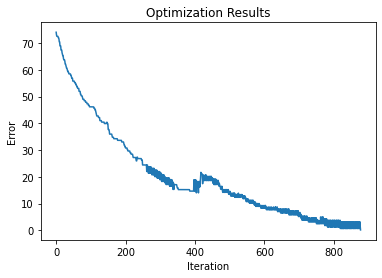

In [44]:
plt.plot(Error_list)
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.title("Optimization Results")
plt.savefig("Optimization Results")

Get optimal Yi, indicates best stock to be selected in index. Now we can use the resutlt to build the index.

In [15]:
Selected_list = []
for i in range(30):
    if Yj[i] == 1:
        Selected_list.append(DJI_COM["COM"].to_list()[i])
Selected_list

['AMGN', 'DIS', 'DOW', 'GS', 'HD', 'INTC', 'JNJ', 'JPM', 'NKE', 'VZ']

In [16]:
c = 0
for i in DJI_COM["COM"].to_list():
    if i in Selected_list:
        print(i, c)
    c+=1

AMGN 2
DIS 9
DOW 10
GS 11
HD 12
INTC 15
JNJ 16
JPM 17
NKE 21
VZ 26


Now we rebuild the index, we will assign the weight of the not selected to the best correlated selected stock.

In [17]:
import numpy as np
arr = xij_0
pairs = np.argwhere(arr == 1)

In [18]:
w2 = 0
w9 = 0
w10 = 0
w11 = 0 
w12 = 0 
w15 = 0 
w16 = 0 
w17 = 0 
w21 = 0 
w26 = 0
for i in pairs:
    if i[1] == 2:
        w2 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 9:
        w9 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 10:
        w10 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 11:
        w11 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 12:
        w12 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 15:
        w15 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 16:
        w16 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 17:
        w17 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 21:
        w21 += DJI_COM["WEIGHT"][i[0]]
    elif i[1] == 26:
        w26 += DJI_COM["WEIGHT"][i[0]]
wl = [w2, w9, w10, w11, w12, w15, w16, w17, w21, w26]

In [19]:
sum_wl = sum(wl)
adj_wl = []
for i in range(len(wl)):
    adj_wl.append(wl[i]/sum(wl))

## Out Sample Test

In [29]:
dji = yf.download('DJI', start='2021-06-01', end='2021-9-30')["Close"]

[*********************100%***********************]  1 of 1 completed


In [30]:
stocks_test = pdr.get_data_yahoo(Selected_list, start='2021-06-01', end='2021-9-30')['Close']
stocks_test.head()

[*********************100%***********************]  10 of 10 completed


,AMGN,DIS,DOW,GS,HD,INTC,JNJ,JPM,NKE,VZ
Date,,,,,,,,,,
2021-06-01,233.580002,178.839996,70.410004,382.440002,316.309998,56.889999,165.529999,166.050003,134.509995,56.380001
2021-06-02,235.160004,177.000000,68.949997,383.440002,313.230011,57.480000,166.199997,166.059998,134.169998,56.650002
2021-06-03,235.740005,176.240005,70.610001,388.720001,311.429993,56.240002,166.039993,166.169998,134.169998,56.980000
2021-06-04,236.850006,177.179993,70.370003,391.450012,311.010010,57.369999,165.970001,166.440002,133.740005,57.299999
2021-06-07,237.190002,176.990005,69.239998,388.160004,309.959991,57.090000,164.839996,165.660004,133.949997,57.200001


make their has the same start value

In [31]:
dji_scaler = dji[0]
dji = dji/dji_scaler

In [32]:
for st in Selected_list:
    st_sc = stocks_test[st][0]
    stocks_test[st] = stocks_test[st]/st_sc

In [33]:
stocks_test["Index"] = adj_wl[0] * stocks_test[Selected_list[0]] + \
                       adj_wl[1] * stocks_test[Selected_list[1]] + \
                       adj_wl[2] * stocks_test[Selected_list[2]] + \
                       adj_wl[3] * stocks_test[Selected_list[3]] + \
                       adj_wl[4] * stocks_test[Selected_list[4]] + \
                       adj_wl[5] * stocks_test[Selected_list[5]] + \
                       adj_wl[6] * stocks_test[Selected_list[6]] + \
                       adj_wl[7] * stocks_test[Selected_list[7]] + \
                       adj_wl[8] * stocks_test[Selected_list[8]] + \
                       adj_wl[9] * stocks_test[Selected_list[9]]

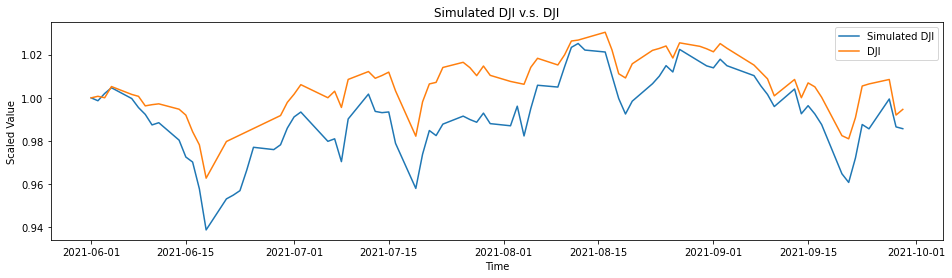

In [43]:
plt.figure(figsize = (16,4))
plt.plot(stocks_test["Index"], label="Simulated DJI")
plt.plot(dji, label="DJI")
plt.xlabel("Time")
plt.ylabel("Scaled Value")
plt.title("Simulated DJI v.s. DJI")
plt.legend()
plt.savefig("Simulated DJI v.s. DJI.png")

From the plot we can see that our built index follows the trend of DJI index quite well.

* The performance might be improved by other weighting methods, eg. based on market value.